In [1]:
# for reading writing and visulaizing the image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for creating the model
import torch
import torchvision
from time import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchsummary import summary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### LOADING THE DATASET

In [3]:
dataset = pd.read_csv('data//train.csv')
pred_dataset =  pd.read_csv('data//test.csv')

In [4]:
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
pred_dataset

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### DEFINING THE DATALOADERS

In [6]:
# .values gives the datasets as numpy arrays and when we give them to dataloaders they automatically transform them to tensors
dataset = dataset.values 
pred_dataset = pred_dataset.values
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (33600, 8400)) # 80% training 
train_dataloader =  DataLoader(train_dataset, batch_size = 16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle= False)

In [7]:
print(next(iter(train_dataloader)).shape)
next(iter(train_dataloader))

torch.Size([16, 785])


tensor([[9, 0, 0,  ..., 0, 0, 0],
        [9, 0, 0,  ..., 0, 0, 0],
        [3, 0, 0,  ..., 0, 0, 0],
        ...,
        [3, 0, 0,  ..., 0, 0, 0],
        [3, 0, 0,  ..., 0, 0, 0],
        [2, 0, 0,  ..., 0, 0, 0]])

In [8]:
print(next(iter(test_dataloader)).shape)
next(iter(test_dataloader))

torch.Size([16, 785])


tensor([[6, 0, 0,  ..., 0, 0, 0],
        [2, 0, 0,  ..., 0, 0, 0],
        [7, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [3, 0, 0,  ..., 0, 0, 0],
        [4, 0, 0,  ..., 0, 0, 0]])

#### DISPLAYING THE IMAGES

In [9]:
def PlotBatch(data_loader, batch_size = 16):
  batch = next(iter(data_loader))  # first batch of data_loader
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    temp = batch[i,1:]
    plt.imshow(temp.reshape(28,28), cmap='gray')
    plt.title(batch[i,0].item())
    plt.axis('off')

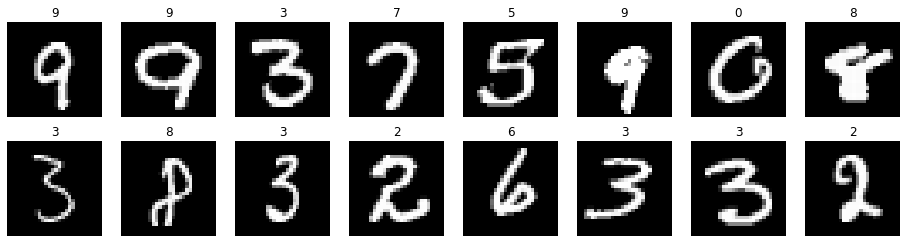

In [10]:
PlotBatch(train_dataloader)

#### MODEL

In [11]:
class MNIST(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size=(3,3), stride = (1,1), padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.fc = nn.Linear(16*7*7, num_classes)
    
  def forward(self, x):
    x = x.reshape(x.shape[0],1,28,28)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1) #(16,1,7,7) is turned into 16,49
    x = self.fc(x)
    return x
    
    

In [12]:
model = MNIST().to(device)
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
         MaxPool2d-2            [-1, 8, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]           1,168
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Linear-5                   [-1, 10]           7,850
Total params: 9,098
Trainable params: 9,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.03
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [13]:
def train(epochs, batch_size = 16, print_every = 50):
  total_loss = 0 # average of losses over all of the batches
  accuracy = []
  tic = time()

  for i, batch in enumerate(train_dataloader,1):  # i represents number of batches starting from 1
    model_input = (batch[:,1:]/255.0).to(device)
    target = (batch[:,0]).to(device)

    model_output = model(model_input)
    loss = criterion(model_output, target)
    total_loss+= loss.item()  # as it is just a tensor of 0 dimension, so converting it to a scalar by .item() method
    # backpropoagation
    optimizer.zero_grad() # making the gradients equal to zero if there are previously any
    loss.backward()
    optimizer.step()  # updating the gradients

    res = model_output.argmax(dim=1)
    accuracy.append((res==target).sum().item()/batch_size) # accuracy over a batch

    if i%print_every==0:   # should print something after every 'print_every' no. of batches are processed
      print('Epoch [{}] ({}/{}), train_loss = {:.4f}, accuracy = {:.2f}, time = {:.2f} sec'.format(epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time() - tic ))
  return total_loss/len(train_dataloader) # returns average loss of all batches


In [14]:
def test(epochs, batch_size = 16, print_every = 50):
  total_loss = 0
  accuracy = []
  tic = time()
  
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader, 0):
      model_input = (batch[:,1:]/255.0).to(device)
      target = (batch[:,0]).to(device)

      model_output = model(model_input)
      loss = criterion(model_output, target)
      total_loss+= loss.item()

      result = model_output.argmax(dim=1)
      accuracy.append((result==target).sum().item()/target.shape[0]) 
  print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-tic
    ))
  return total_loss/len(test_dataloader) # Returning Average Testing Loss

In [15]:
lr = 1e-4
model = MNIST().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [16]:
train_loss = []
test_loss = []
for epoch in range(1, 10):
  train_loss.append(train(epoch, batch_size=16, print_every=500 ))
  test_loss.append(test(epoch, batch_size = 16, print_every=500 ))
  print("\n")

Epoch [1] (500/2100), train_loss = 0.9641, accuracy = 0.53, time = 8.51 sec
Epoch [1] (1000/2100), train_loss = 0.4035, accuracy = 0.67, time = 16.50 sec
Epoch [1] (1500/2100), train_loss = 0.1999, accuracy = 0.74, time = 24.55 sec
Epoch [1] (2000/2100), train_loss = 0.2154, accuracy = 0.77, time = 32.72 sec
Epoch: [1], Test Loss: 0.3865, Accuracy: 0.88, Time: 2.70 sec


Epoch [2] (500/2100), train_loss = 0.3683, accuracy = 0.90, time = 8.01 sec
Epoch [2] (1000/2100), train_loss = 0.2472, accuracy = 0.90, time = 15.81 sec
Epoch [2] (1500/2100), train_loss = 0.1046, accuracy = 0.90, time = 23.53 sec
Epoch [2] (2000/2100), train_loss = 0.2208, accuracy = 0.90, time = 31.65 sec
Epoch: [2], Test Loss: 0.2986, Accuracy: 0.91, Time: 2.47 sec


Epoch [3] (500/2100), train_loss = 0.2970, accuracy = 0.92, time = 8.08 sec
Epoch [3] (1000/2100), train_loss = 0.1742, accuracy = 0.92, time = 15.67 sec
Epoch [3] (1500/2100), train_loss = 0.0791, accuracy = 0.92, time = 23.64 sec
Epoch [3] (2000/2100

In [20]:
# trying for 9 more epochs
for epoch in range(10, 20):
  train_loss.append(train(epoch, batch_size=16, print_every=500 ))
  test_loss.append(test(epoch, batch_size = 16, print_every=500 ))
  print("\n")

Epoch [10] (500/2100), train_loss = 0.0734, accuracy = 0.97, time = 10.17 sec
Epoch [10] (1000/2100), train_loss = 0.0739, accuracy = 0.97, time = 20.14 sec
Epoch [10] (1500/2100), train_loss = 0.0189, accuracy = 0.97, time = 30.07 sec
Epoch [10] (2000/2100), train_loss = 0.0266, accuracy = 0.97, time = 40.05 sec
Epoch: [10], Test Loss: 0.1090, Accuracy: 0.97, Time: 3.52 sec


Epoch [11] (500/2100), train_loss = 0.0676, accuracy = 0.97, time = 9.90 sec
Epoch [11] (1000/2100), train_loss = 0.0636, accuracy = 0.97, time = 20.98 sec
Epoch [11] (1500/2100), train_loss = 0.0165, accuracy = 0.97, time = 27.71 sec
Epoch [11] (2000/2100), train_loss = 0.0223, accuracy = 0.97, time = 34.71 sec
Epoch: [11], Test Loss: 0.1028, Accuracy: 0.97, Time: 2.85 sec


Epoch [12] (500/2100), train_loss = 0.0650, accuracy = 0.97, time = 7.18 sec
Epoch [12] (1000/2100), train_loss = 0.0550, accuracy = 0.97, time = 14.43 sec
Epoch [12] (1500/2100), train_loss = 0.0147, accuracy = 0.97, time = 21.53 sec
Epoch 

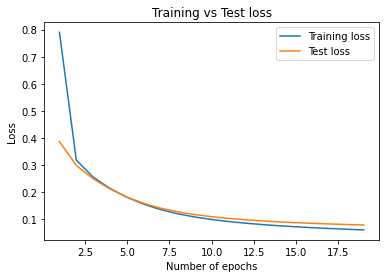

In [21]:
# plotting the test vs train loss curve
plt.plot(range(1, len(train_loss)+1), train_loss, label = "Training loss")
plt.plot(range(1, len(test_loss)+1), test_loss, label = "Test loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title("Training vs Test loss")
plt.legend()
plt.show()

In [22]:
# checking our results visually on the pred_set
def Check_model(start):  # from which example we have to plot
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    img_num = start + i
    input = ((torch.tensor(pred_dataset[img_num,:])/255.0).reshape(1,784)).to(device)
    op = model(input)
    pred = op.argmax(dim=1).item()
    fig.add_subplot(2,8,i+1)
    input = input.to('cpu') # have to add this line as input was on gpu
    plt.imshow(input.reshape([28,28]), cmap = 'gray')
    plt.title(pred)
    plt.axis('off')

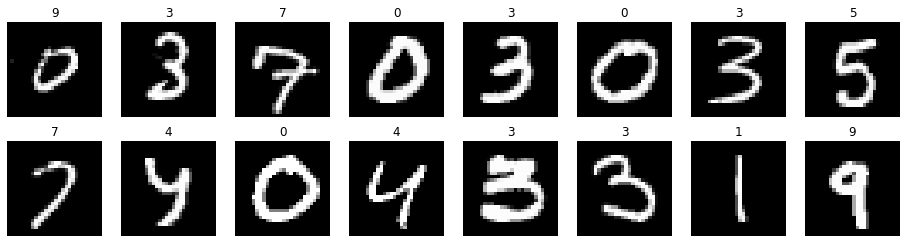

In [23]:
Check_model(3)  # model is performing quite well on the test set(acc=0.95) and on the pred set(by seeing the visualizations)

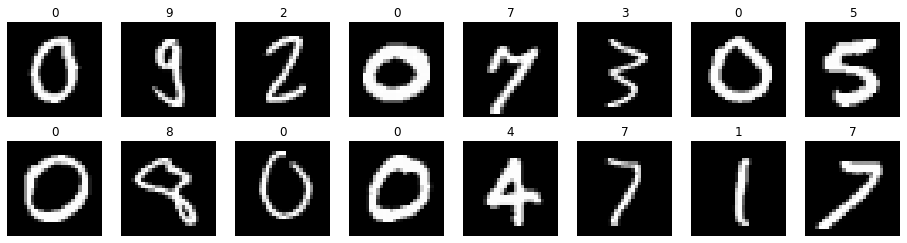

In [24]:
Check_model(100)

In [25]:
# predictions on the pred datset
def pred():
  image_id = np.arange(1, pred_dataset.shape[0]+1).reshape(pred_dataset.shape[0],1)
  res = np.zeros((pred_dataset.shape[0],1))
  for i in range(pred_dataset.shape[0]):
    input = ((torch.tensor(pred_dataset[i,:])/255.0).reshape(1,784)).to(device)
    op = model(input)
    ans = op.argmax(dim=1).item()
    res[i] = ans
  pred_df = pd.DataFrame(np.concatenate((image_id.astype(np.int), res.astype(np.int)), axis=1))
  pred_df.columns = ['ImageId', 'Label']
  return pred_df

In [26]:
pred_df = pred()
pred_df.head()

C:\Users\Ayush\AppData\Local\Temp/ipykernel_17128/452453351.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_df = pd.DataFrame(np.concatenate((image_id.astype(np.int), res.astype(np.int)), axis=1))


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [27]:
# model is performing well, so let's make a submission
submission = pred_df.to_csv('Submission1.csv')